In [1]:
import numpy as np

In [2]:
def world_to_pixel(world_coords, camera_params, rotation_matrix):
    # Extract camera parameters
    camera_position = np.array(camera_params['camera_position'])
    fov = camera_params['fov']
    width, height = camera_params['image_resolution']
    pixel_width = camera_params['camera_sensor_width'] / width
    pixel_height = camera_params['camera_sensor_height'] / height

    # Calculate the direction vector from the camera position to the 3D point
    direction = (world_coords - camera_position).astype(np.float64)

    # Normalize the direction vector
    direction /= np.linalg.norm(direction)

    # Apply the inverse rotation matrix to align with the camera's view
    inv_rotation_matrix = np.linalg.inv(rotation_matrix)
    direction = np.dot(inv_rotation_matrix, direction)

    # Project the 3D point onto the 2D image plane
    # Assuming the camera is looking along the z-axis, ignore the z-component
    u = direction[0] * fov / 2
    v = direction[1] * fov / 2

    # Convert from camera coordinates to pixel indices
    x_index = int((u / pixel_width) + width / 2)
    y_index = int((v / pixel_height) + height / 2)

    return x_index, y_index

In [3]:
# Example usage:
camera_params = {
    'fov': 49.9,  # Field of view in degrees
    'camera_position': [3, 3, 6],  # Camera position (x, y, z)
    'camera_rotation': [-25, 25, 0],  # Camera rotation in degrees (pitch, roll, yaw)
    'camera_sensor_width': 36,  # Camera sensor width in mm
    'camera_sensor_height': 24,  # Camera sensor height in mm
    'image_resolution': [320, 240]  # Image resolution (width, height)
}

# Calculate the camera rotation matrix
pitch = camera_params['camera_rotation'][0] * np.pi / 180
roll = camera_params['camera_rotation'][1] * np.pi / 180
yaw = camera_params['camera_rotation'][2] * np.pi / 180

rotation_matrix = np.array([
    [np.cos(yaw) * np.cos(pitch), np.cos(yaw) * np.sin(pitch) * np.sin(roll) - np.sin(yaw) * np.cos(roll), np.cos(yaw) * np.sin(pitch) * np.cos(roll) + np.sin(yaw) * np.sin(roll)],
    [np.sin(yaw) * np.cos(pitch), np.sin(yaw) * np.sin(pitch) * np.sin(roll) + np.cos(yaw) * np.cos(roll), np.sin(yaw) * np.sin(pitch) * np.cos(roll) - np.cos(yaw) * np.sin(roll)],
    [-np.sin(pitch), np.cos(pitch) * np.sin(roll), np.cos(pitch) * np.cos(roll)]
])

# Example 3D world coordinates
world_coords = [4, 4, 7]

# Convert 3D coordinates to 2D pixel coordinates
pixel_coords = world_to_pixel(world_coords, camera_params, rotation_matrix)
print("Pixel Coordinates:", pixel_coords)

Pixel Coordinates: (330, 279)


In [4]:
import cv2
import numpy as np
from matplotlib.pyplot import imshow
class ColorMasker:
    def __init__(self, image):
        self.image = image
        self.hsv_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2HSV)
        self.color_ranges = {
            'gray': ((0, 0, 40), (30, 20, 100)),
            'red': (((0, 100, 100), (10, 255, 255)), ((160, 100, 100), (180, 255, 255))),
            'blue': ((110, 50, 50), (130, 255, 255)),
            'green': ((30, 70, 60), (60, 255, 255)),
            'brown': ((10, 100, 20), (20, 255, 200)),
            'cyan': ((80, 90, 60), (100, 255, 255)),
            'purple': ((130, 50, 50), (160, 255, 255)),
            'yellow': ((25, 100, 100), (30, 255, 255))
        }

    def separate_objects(self, mask):
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        masks = []
        for contour in contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                temp_mask = np.zeros_like(mask)
                cv2.drawContours(temp_mask, [contour], -1, 255, thickness=cv2.FILLED)
                masks.append(temp_mask)
        return masks

    def get_mask(self, color_code):
        if color_code not in self.color_ranges:
            raise ValueError("Invalid color code")
        
        ranges = self.color_ranges[color_code]
        if color_code == 'red':  # Red has two ranges
            mask1 = cv2.inRange(self.hsv_image, np.array(ranges[0][0], dtype=np.uint8), np.array(ranges[0][1], dtype=np.uint8))
            mask2 = cv2.inRange(self.hsv_image, np.array(ranges[1][0], dtype=np.uint8), np.array(ranges[1][1], dtype=np.uint8))
            mask = cv2.bitwise_or(mask1, mask2)
        else:
            mask = cv2.inRange(self.hsv_image, np.array(ranges[0], dtype=np.uint8), np.array(ranges[1], dtype=np.uint8))
        
        return self.separate_objects(mask)
        
    def get_mask_arg(self, mask, predicted_centers):
        true_indices = np.where(mask)
        x_mask, y_mask = (int(np.mean(true_indices[0])), int(np.mean(true_indices[1])))
        
        # Convert predicted_centers to a numpy array if it's not already one
        predicted_centers = np.array(predicted_centers)
        
        # Calculate the squared Euclidean distances to all predicted centers
        distances = np.sum((predicted_centers - np.array([x_mask, y_mask]))**2, axis=1)

        # Find the index of the closest center
        closest_index = np.argmin(distances)

        # Get the closest center coordinates
        closest_center = predicted_centers[closest_index]

        return closest_center
        

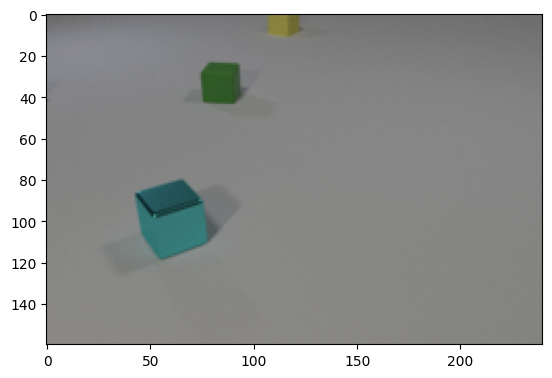

In [5]:
# Usage
image_1 = cv2.imread("dataset/train/video_00000/image_0.png")
imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))

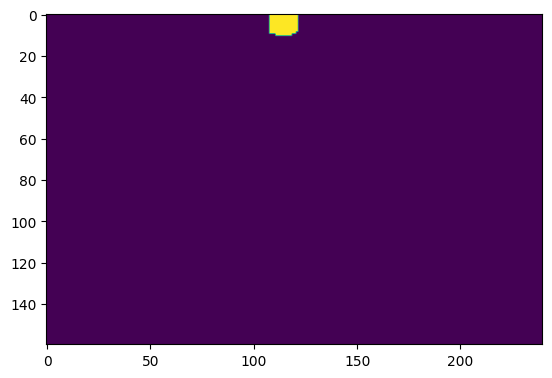

In [6]:
masker_1 = ColorMasker(image_1)
color_code = 'yellow'  # Example color code
mask_yellow = masker_1.get_mask(color_code)
    
imshow(mask_yellow)

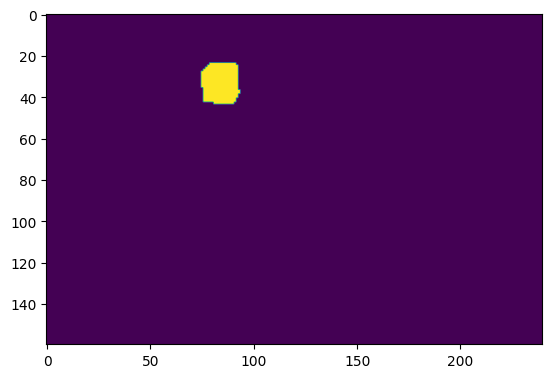

In [7]:
color_code = 'green'  # Example color code
mask_green = masker_1.get_mask(color_code)
    
imshow(mask_green[0])

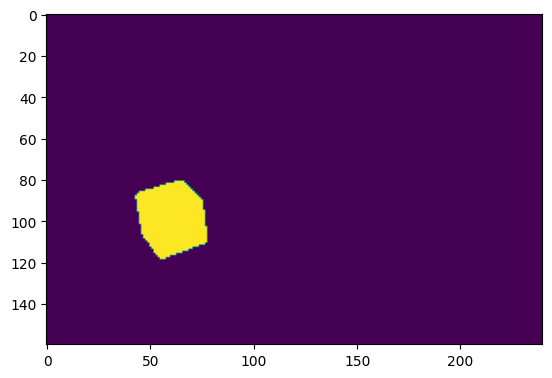

In [8]:
color_code = 'cyan'  # Example color code
mask_cyan = masker_1.get_mask(color_code)
    
imshow(mask_cyan[0])

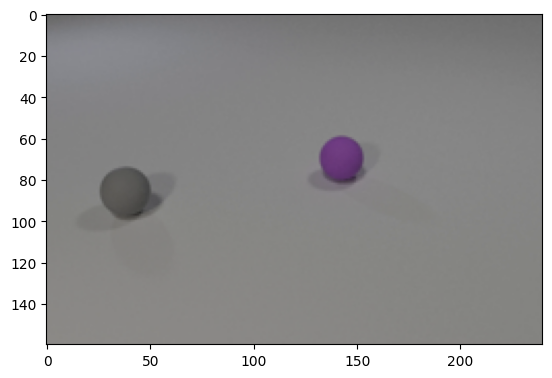

In [9]:
# Usage
image_2 = cv2.imread("dataset/train/video_00002/image_0.png")
imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB))

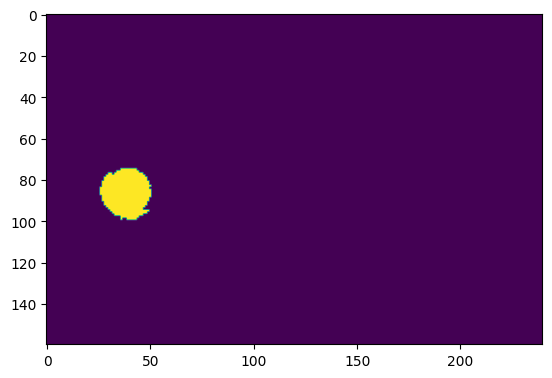

In [10]:
masker_2 = ColorMasker(image_2)
color_code = 'gray'  # Example color code
mask_grey = masker_2.get_mask(color_code)
    
imshow(mask_grey[0])

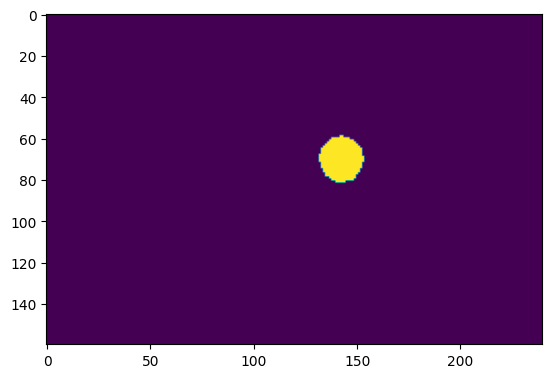

In [11]:
color_code = 'purple'  # Example color code
mask_purple = masker_2.get_mask(color_code)
    
imshow(mask_purple[0])

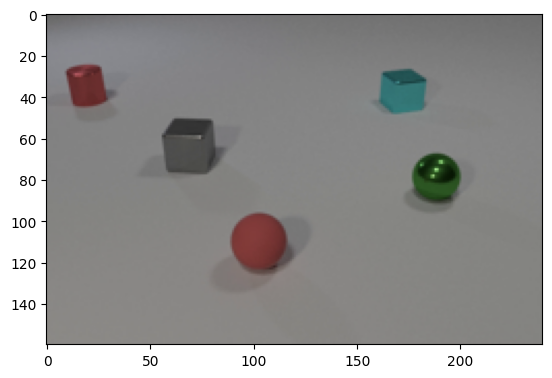

In [12]:
# Usage
image_3 = cv2.imread("dataset/train/video_00003/image_0.png", cv2.IMREAD_COLOR)
imshow(cv2.cvtColor(image_3, cv2.COLOR_BGR2RGB))

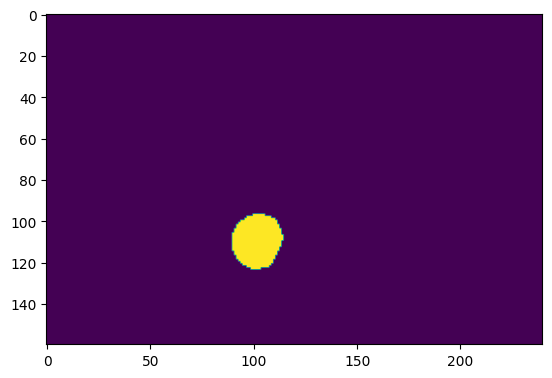

In [13]:
masker_3 = ColorMasker(image_3)
color_code = 'red'  # Example color code
mask_red = masker_3.get_mask(color_code)
    
imshow(mask_red[0])

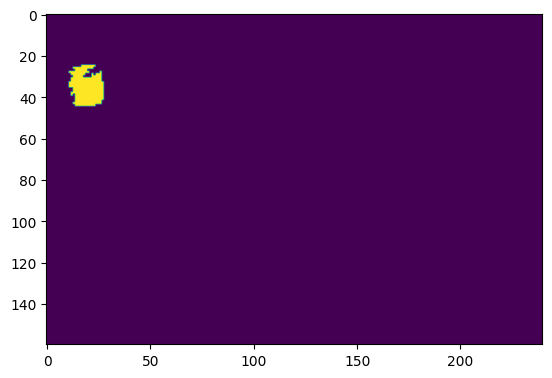

In [14]:
imshow(mask_red[1])

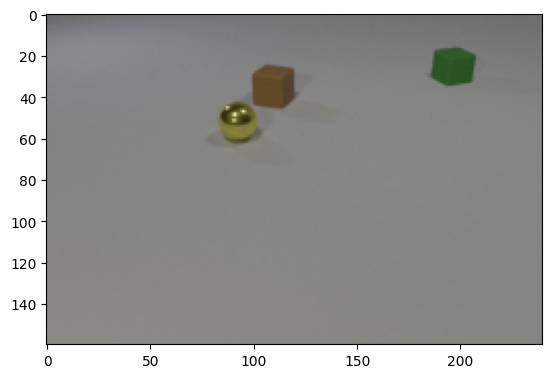

In [15]:
image_4 = cv2.imread("dataset/train/video_00004/image_0.png", cv2.IMREAD_COLOR)
imshow(cv2.cvtColor(image_4, cv2.COLOR_BGR2RGB))

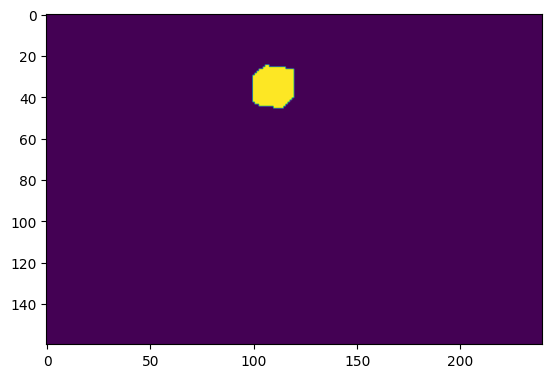

In [16]:
masker_4 = ColorMasker(image_4)
color_code = 'brown'  # Example color code
mask_brown = masker_4.get_mask(color_code)
    
imshow(mask_brown[0])